## **Final Project BA865 - Predicting Yelp Reviews Usefulness**
*Raviv Zait*

This project's goal is to use Neural Network models to predict Yelp reviews 'Usefulness' score, i.e., how many Yelp users will vote for a given review as "Useful" to their decision of whether to buy from that business or not. The users can also vote for the review as "Funny" or "Cool".
For this purpose, I will use a dataset containing Yelp reviews of coffee shops in Boston. I scraped the data using "Yelp Scraper" from Apify.com. The downloaded data includes 200 businesses on Yelp.com that matched the search keyword "Coffee" in the location "Boston". Businesses in the dataset have up to 100 reviews each, and after removing missing texts the dataset has 14,500 reviews.

Throughout this project, I am experimenting with different NN models and architectures, some of which were constrained by computing limitations. Overall, different models reach similar scores of around 65-70% accuracy for usefulness in the binary classification, and 60% in the multi-class prediction. I also build a multiple-output model to predict a binary classification of all 3 labels at once, and use cosine similarity to compare reviews with different labels.

The project has 5 main parts:

1. Data processing and preperation for analysis
2. Predicting binary usefulness classification - useful or not
3. Predicting a multi-class classification
4. Predicting a binary classification for multiple outputs: Useful, Funny, and Cool scores
5. Interpertation - reviewing text similarities and LIME word importance analysis



#1. Data processing and preperation for analysis

Importing packages and modules

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Embedding, Dense, concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import regex as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data uploading

In [ ]:
from google.colab import files
# upload "boston_coffee_yelp_reviews.csv"
uploaded = files.upload()

Saving yelp_3.4.csv to yelp_3.4.csv


Downloading the Glove embeddings file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-02 20:59:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-02 20:59:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-02 20:59:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Data processing

In [ ]:
df=pd.read_csv('boston_coffee_yelp_reviews.csv')
df.head(1)

,bizId,name,aggregatedRating,healthScore,priceRange,reviewCount,address/addressLine1,address/addressLine2,address/addressLine3,address/city,...,reviews/99/photoUrls/0,reviews/99/photoUrls/1,reviews/99/photoUrls/2,reviews/99/photoUrls/3,reviews/99/rating,reviews/99/reviewerLocation,reviews/99/reviewerName,reviews/99/reviewerReviewCount,reviews/99/reviewerUrl,reviews/99/text
0,d9M55B8vjwJ5tka3p8104g,Caffe Strega,4.0,NaN,NaN,3,177 Huntington Ave,NaN,NaN,Boston,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(200, 1523)

In [ ]:
print(f'shape of file: {df.shape}')
print(f'first 24 column names: {df.columns[:24]}')

shape of file: (200, 1523)
first 24 column names: Index(['bizId', 'name', 'aggregatedRating', 'healthScore', 'priceRange',
       'reviewCount', 'address/addressLine1', 'address/addressLine2',
       'address/addressLine3', 'address/city', 'address/country',
       'address/postalCode', 'address/regionCode', 'images/0/alt',
       'images/0/link', 'images/1/alt', 'images/1/link', 'images/2/alt',
       'images/2/link', 'images/3/alt', 'images/3/link', 'images/4/alt',
       'images/4/link', 'reviews/0/date'],
      dtype='object')


Each row in the data represents a business. Since we are interested in predicting review helpfulness, the data needs reshaping. The data structure shows that the first 23 columns are the business data, and the other 1500 are the reviews: 15 columns per review, 100 reviews per business. Before reshaping, let's check if in fact these columns are mostly filled with reviews.

In [ ]:
# Define the list of column names
col_names_text = ['reviews/{}/text'.format(i) for i in range(100)]
total_text_na = 0
# Count the number of NaN values in each column
for col in col_names_text:
    text_na = df[col].isna().sum()
    print(f"{col}: {text_na} na")
    total_text_na += text_na

print(f'Total na: {total_text_na}')

reviews/0/text: 0 na
reviews/1/text: 4 na
reviews/2/text: 10 na
reviews/3/text: 14 na
reviews/4/text: 14 na
reviews/5/text: 14 na
reviews/6/text: 17 na
reviews/7/text: 19 na
reviews/8/text: 20 na
reviews/9/text: 20 na
reviews/10/text: 21 na
reviews/11/text: 22 na
reviews/12/text: 23 na
reviews/13/text: 23 na
reviews/14/text: 25 na
reviews/15/text: 26 na
reviews/16/text: 28 na
reviews/17/text: 29 na
reviews/18/text: 31 na
reviews/19/text: 34 na
reviews/20/text: 34 na
reviews/21/text: 37 na
reviews/22/text: 38 na
reviews/23/text: 40 na
reviews/24/text: 40 na
reviews/25/text: 40 na
reviews/26/text: 40 na
reviews/27/text: 41 na
reviews/28/text: 41 na
reviews/29/text: 43 na
reviews/30/text: 45 na
reviews/31/text: 47 na
reviews/32/text: 48 na
reviews/33/text: 49 na
reviews/34/text: 50 na
reviews/35/text: 50 na
reviews/36/text: 51 na
reviews/37/text: 51 na
reviews/38/text: 51 na
reviews/39/text: 51 na
reviews/40/text: 52 na
reviews/41/text: 53 na
reviews/42/text: 53 na
reviews/43/text: 56 na


Every business has at least one review, and most businesses have 100 reviews; however there are 5500 missing texts so we will remove those reviews after reshaping.
The original scraped file has reviews for 200 businesses, each has between 1 and 100 reviews. For each review, there are 15 features : date; Cool/Funny/Useful counts; language; review photos; rating; reviwer name, location, review counts and personal url; and review text.
Thus, to have the data in long format (i.e, every review is a row), the last 1500 columns will be reshaped. the first 23 columns remain constant as id variables - they remain the same for each business.

In [ ]:
id_vars=df.columns[:23]
id_vars

Index(['bizId', 'name', 'aggregatedRating', 'healthScore', 'priceRange',
       'reviewCount', 'address/addressLine1', 'address/addressLine2',
       'address/addressLine3', 'address/city', 'address/country',
       'address/postalCode', 'address/regionCode', 'images/0/alt',
       'images/0/link', 'images/1/alt', 'images/1/link', 'images/2/alt',
       'images/2/link', 'images/3/alt', 'images/3/link', 'images/4/alt',
       'images/4/link'],
      dtype='object')

In [ ]:
id_vars=df.columns[:23]

#renaming columns to fit the format of pandas' 'wide to long' function
df = df.rename(columns=lambda x: re.sub('reviews/(\d{1,2})/(.*)', r'review_\2\1', x))
#reshaping the data
df = pd.wide_to_long(df,
                     stubnames=['review_date', 'review_isCoolCount', 'review_isFunnyCount',
       'review_isUsefulCount', 'review_language', 'review_photoUrls/0',
       'review_photoUrls/1', 'review_photoUrls/2', 'review_photoUrls/3',
       'review_rating', 'review_reviewerLocation', 'review_reviewerName',
       'review_reviewerReviewCount', 'review_reviewerUrl', 'review_text'],
                     i=id_vars,
                     j='review_number').reset_index()


In [ ]:
#checking the final columns to see the reshape worked
df.shape

(20000, 39)

After reshaping, there are 100 rows for every business - total of 20000 rows. However, we know there were 5500 missing reviews. Let's verify and remove them.

In [ ]:
df['review_text'].isna().sum()

5500

In [ ]:
df.dropna(subset=['review_text'], inplace=True)

We also need to remove rows without any label out of: `review_isCoolCount`, `review_isFunnyCount`, `review_isUsefulCount`, in case there are such rows

In [ ]:
df.dropna(subset=['review_isCoolCount' ,'review_isFunnyCount', 'review_isUsefulCount'], how='all', inplace=True)

In [ ]:
df.shape

(14500, 39)

Now all reviews have both text and at least one label. Next, we will remove columns which are not relevant/useful for analysis

In [ ]:
df.columns

Index(['bizId', 'name', 'aggregatedRating', 'healthScore', 'priceRange',
       'reviewCount', 'address/addressLine1', 'address/addressLine2',
       'address/addressLine3', 'address/city', 'address/country',
       'address/postalCode', 'address/regionCode', 'images/0/alt',
       'images/0/link', 'images/1/alt', 'images/1/link', 'images/2/alt',
       'images/2/link', 'images/3/alt', 'images/3/link', 'images/4/alt',
       'images/4/link', 'review_number', 'review_date', 'review_isCoolCount',
       'review_isFunnyCount', 'review_isUsefulCount', 'review_language',
       'review_photoUrls/0', 'review_photoUrls/1', 'review_photoUrls/2',
       'review_photoUrls/3', 'review_rating', 'review_reviewerLocation',
       'review_reviewerName', 'review_reviewerReviewCount',
       'review_reviewerUrl', 'review_text'],
      dtype='object')

In [ ]:
df['review_language'].describe()

count     14500
unique        1
top          en
freq      14500
Name: review_language, dtype: object

All reviews are in English - we can remove the column


In [ ]:
df.drop(['review_language'], axis=1, inplace=True)

We can also keep just the country and city information on the reviewer, and remove the postal/region codes and the current location

In [ ]:
df.drop(['address/postalCode', 'address/regionCode', 'review_reviewerLocation'], axis=1, inplace=True)

In [ ]:
#one-hot encoding to categorical variables
categories = ['Under $10', '$11-30', 'Inexpensive', 'Moderate', '$31-60', 'Above $61']
df['priceRange'] = pd.Categorical(df['priceRange'], categories=categories, ordered=True)

categories = ['Pass with no violations', 'Pass with minor violations', 'Violations found; re-inspection required']
df['healthScore'] = pd.Categorical(df['healthScore'], categories=categories, ordered=True)

cols_to_encode = ['priceRange', 'address/country', 'bizId', 'address/city', 'healthScore']
df = pd.get_dummies(df, columns = cols_to_encode, drop_first=True)

print(df.shape)

(14500, 258)


In [ ]:
# changing the date column into date type and then to an ordinal (int) value to count number of days since 1/1 AD
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date'] = df['review_date'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

We'll standardize the numerical colums

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cols_to_normalize = ['reviewCount', 'aggregatedRating', 'review_reviewerReviewCount', 'review_date']

scaler = StandardScaler()
scaler.fit(df[cols_to_normalize])
df[cols_to_normalize]=scaler.transform(df[cols_to_normalize])

df['review_rating'] = df['review_rating']/5 #getting the review rating to be 0-1 instead of 1-5

In [ ]:
# dropping unnecessary columns / those with many missing valuesfor current prediction analysis
df.drop(['images/0/alt', 'images/0/link', 'images/1/alt', 'images/1/link',
       'images/2/alt', 'images/2/link', 'images/3/alt', 'images/3/link',
       'images/4/alt', 'images/4/link', 'name', 'review_reviewerUrl','review_reviewerName','address/addressLine2', 'address/addressLine3','review_photoUrls/0',
       'review_photoUrls/1', 'review_photoUrls/2', 'review_photoUrls/3', 'address/addressLine1' ], axis=1, inplace=True)
print(df.shape)

(14500, 238)


Let's examine the labels distribution:

In [ ]:
target_variables = ['review_isCoolCount', 'review_isFunnyCount', 'review_isUsefulCount']
df[target_variables].describe()

,review_isCoolCount,review_isFunnyCount,review_isUsefulCount
count,14500.000000,14500.000000,14500.000000
mean,0.622690,0.357448,1.117724
std,3.627842,2.183593,3.996688
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,331.000000,189.000000,332.000000


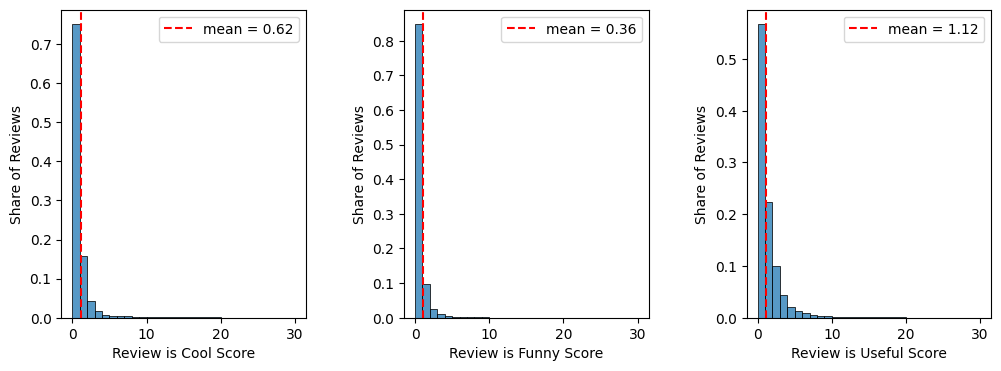

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4),  gridspec_kw={'wspace': 0.4})

mean_use = df['review_isUsefulCount'].mean()
mean_cool = df['review_isCoolCount'].mean()
mean_funny = df['review_isFunnyCount'].mean()
median_use = df['review_isUsefulCount'].median()
median_cool = df['review_isCoolCount'].median()
median_funny = df['review_isFunnyCount'].median()

sns.histplot(df['review_isCoolCount'], ax=ax[0], bins=[0, 1,2, 3,4, 5,6,7,8,9, 10, 20, 30], stat='density', common_norm=False)
ax[0].set_xlabel('Review is Cool Score', fontsize=10)
ax[0].set_ylabel('Share of Reviews', fontsize=10)
ax[0].axvline(mean_use, color='r', linestyle='--',  label='mean = {:.2f}'.format(mean_cool))
ax[0].legend()

sns.histplot(df['review_isFunnyCount'], ax=ax[1], bins=[0, 1,2, 3,4, 5,6,7,8,9, 10, 20, 30], stat='density', common_norm=False)
ax[1].set_xlabel('Review is Funny Score', fontsize=10)
ax[1].set_ylabel('Share of Reviews', fontsize=10)
ax[1].axvline(mean_use, color='r', linestyle='--',  label='mean = {:.2f}'.format(mean_funny))
ax[1].legend()

sns.histplot(df['review_isUsefulCount'], ax=ax[2], bins=[0, 1,2, 3,4, 5,6,7,8,9, 10, 20, 30], stat='density', common_norm=False)
ax[2].set_xlabel('Review is Useful Score', fontsize=10)
ax[2].set_ylabel('Share of Reviews', fontsize=10)
ax[2].axvline(mean_use, color='r', linestyle='--',  label='mean = {:.2f}'.format(mean_use))
ax[2].legend()
plt.show()


All the labels have a very skewed distributions, with most labels having 0 values. I am focusing on Usefulness, and since 0 scores are a little over 50% of the labels, I will do classification prediction and not regression. In the next step I will relabel the data and address the class imbalance.

##Preparing the data for models

Importing required packages

In [ ]:
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.optimizers import RMSprop

In [ ]:
# setting the labels to be the review "useful", "funny", or "cool" counts
labels = np.asarray(df['review_isUsefulCount'])
labels_funny = np.asarray(df['review_isFunnyCount'])
labels_cool = np.asarray(df['review_isCoolCount'])

# shuffle the indices
np.random.seed(42)

shuffled_indices = np.random.permutation(len(df))

# split the indices into training and testing sets
train_indices = shuffled_indices[:int(0.8*len(shuffled_indices))]
test_indices = shuffled_indices[int(0.8*len(shuffled_indices)):]

# split the data using the indices
text_data = df['review_text'].to_numpy()
other_data = df.drop(['review_isCoolCount' ,'review_isFunnyCount', 'review_isUsefulCount','review_text'], axis=1).values
labels_classification = (labels > 0).astype(int)

text_train = text_data[train_indices]
other_train = other_data[train_indices]
y_class_train = labels_classification[train_indices]

text_test = text_data[test_indices]
other_test = other_data[test_indices]
y_class_test = labels_classification[test_indices]

for i in [text_train, other_train, y_class_train, text_test, other_test, y_class_test ]:
  print(i.shape)

(11600,)
(11600, 234)
(11600,)
(2900,)
(2900, 234)
(2900,)


In [ ]:
print(f'There are ~{round(np.mean(labels_classification),3)*100}% "1" labels in the dataset')
print(f'There are ~{round(np.mean(y_class_train),3)*100}% "1" labels in the training data')
print(f'There are ~{round(np.mean(y_class_test),3)*100}% "1" labels in the test data')

There are ~43.4% "1" labels in the dataset
There are ~43.0% "1" labels in the training data
There are ~45.0% "1" labels in the test data


We have a small balance - about 43% of the reviews are labeld as 'Useful'. We can address that using class weights during fitting.

In [ ]:
total_samples = len(labels_classification)
class_weights = {0: total_samples / (2 * np.sum(labels_classification == 0)),
                 1: total_samples / (2 * np.sum(labels_classification == 1))}
class_weights

{0: 0.8830694275274056, 1: 1.152623211446741}

In [ ]:
# Vectorizing the text, here for one-hot encoding
text_vectorization = keras.layers.TextVectorization(max_tokens = 8000, output_mode="multi_hot", ngrams=(2,1))
text_vectorization.adapt(text_data)
temp = text_vectorization(text_train)
print(temp.shape)

(11600, 8000)


#2. Binary Classification

## Dummy Model

To have a benchmark for the model, first I will use a simple 1-layer network with sigmoid activation function using only non-text data

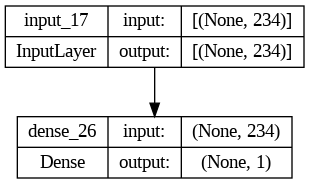

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Reshape

def dummy_model():

    inputs = keras.Input(shape=(other_train.shape[1],), dtype = "float32")
    x = keras.layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, x)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
model = dummy_model()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model = dummy_model()
model.fit(other_train, y_class_train, class_weight=class_weights)

test_acc = model.evaluate(other_test, y_class_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

91/91 [==============================] - 0s 881us/step - loss: 0.6699 - accuracy: 0.6021
The resulting model is about 60.21% accurate in the holdout sample.


## Model 0 - Bag of Words

Let's use the review text for prediction. First, a simple Bag-of-Words model, using only the review text.

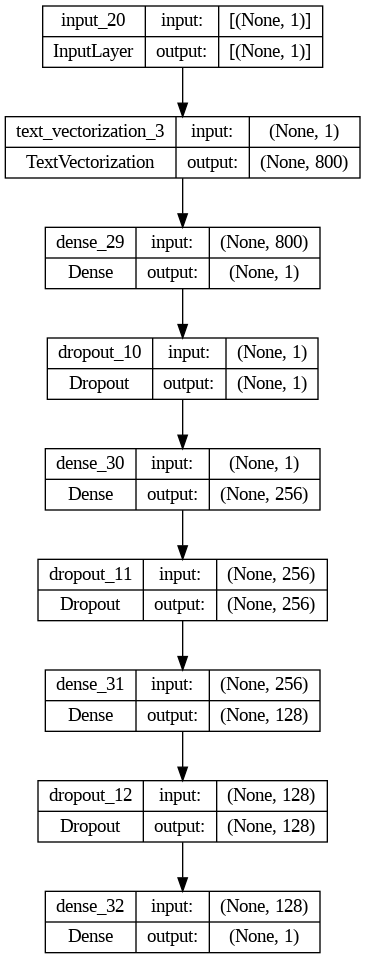

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Reshape

def build_model_bow():
  inputs = keras.Input(shape=(1), dtype=tf.string)
  processing = text_vectorization(inputs)
  x = keras.layers.Dense(inputs.shape[1], activation="relu")(processing)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(256, activation="relu", kernel_regularizer='l1')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(128, activation="relu")(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)
  model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
  return model
model_bow = build_model_bow()

keras.utils.plot_model(model_bow, show_shapes=True)


In [ ]:
# Define number of folds for cross-validation
n_folds = 3

# Define cross-validation split
kfold = KFold(n_splits=n_folds)

# Train model using cross-validation
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []
num_epochs = 20
for fold, (train_idx, val_idx) in enumerate(kfold.split(text_train, y_class_train)):
    print(f"Fold {fold+1}:")
    # Get train and validation data for this fold
    text_train_fold,  y_train_fold = text_train[train_idx], y_class_train[train_idx]
    text_val_fold,  y_val_fold = text_train[val_idx], y_class_train[val_idx]
    model = build_model_bow()
    # Train model for this fold
    history = model.fit(text_train_fold, y_train_fold, epochs=num_epochs,batch_size=16,
                        validation_data=(text_val_fold, y_val_fold), verbose=1, class_weight=class_weights)

    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    acc_history = history.history['accuracy']
    val_history = history.history['val_accuracy']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_history)


Fold 1:
Epoch 1/20
484/484 [==============================] - 2s 3ms/step - loss: 0.7825 - accuracy: 0.5345 - val_loss: 0.6986 - val_accuracy: 0.4388
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 0.6969 - accuracy: 0.4997 - val_loss: 0.6934 - val_accuracy: 0.5676
Epoch 3/20
484/484 [==============================] - 1s 2ms/step - loss: 0.7036 - accuracy: 0.5171 - val_loss: 0.6926 - val_accuracy: 0.5676
Epoch 4/20
484/484 [==============================] - 1s 2ms/step - loss: 0.7066 - accuracy: 0.5200 - val_loss: 0.6947 - val_accuracy: 0.4668
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 0.6999 - accuracy: 0.5063 - val_loss: 0.6884 - val_accuracy: 0.5676
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.7030 - accuracy: 0.5038 - val_loss: 0.6913 - val_accuracy: 0.5676
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.5116 - val_loss: 0.6918 - val_accuracy: 0.476

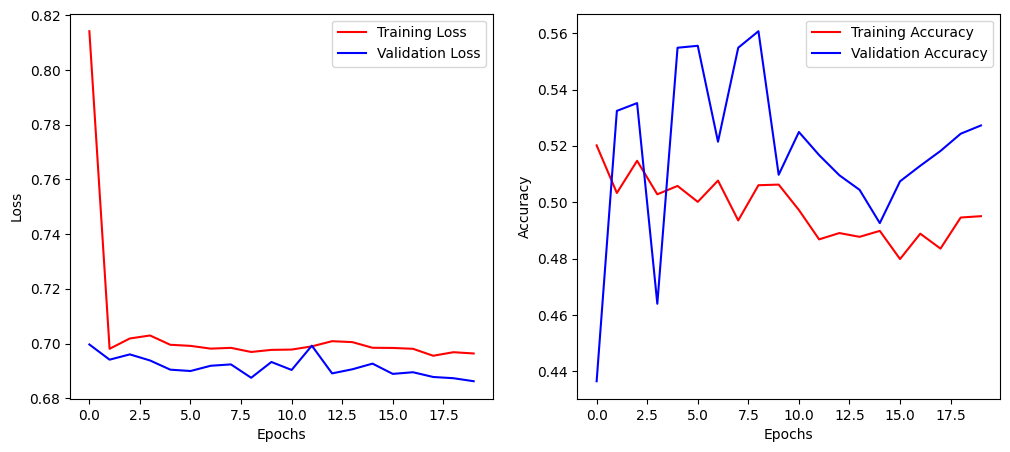

In [ ]:
# plotting the loss and accuracy side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss performance
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
axs[0].plot(average_loss_history,c='r')
axs[0].plot(average_val_loss_history,c='b')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training Loss','Validation Loss'])

# Plot accuracy performance
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
axs[1].plot(average_acc_history,c='r')
axs[1].plot(average_val_acc_history,c='b')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(['Training Accuracy','Validation Accuracy'])

plt.show()

In [ ]:
from keras.models import load_model
model = build_model_bow()
model.fit(text_train, y_class_train,epochs=5,batch_size=16, class_weight=class_weights)

test_acc = model.evaluate(text_test, y_class_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/5
725/725 [==============================] - 2s 2ms/step - loss: 0.7703 - accuracy: 0.5196
Epoch 2/5
725/725 [==============================] - 1s 2ms/step - loss: 0.7018 - accuracy: 0.5375
Epoch 3/5
725/725 [==============================] - 1s 2ms/step - loss: 0.7013 - accuracy: 0.5282
Epoch 4/5
725/725 [==============================] - 1s 2ms/step - loss: 0.7014 - accuracy: 0.5241
Epoch 5/5
91/91 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5538
The resulting model is about 55.38% accurate in the holdout sample.


In [ ]:
#Setting the embedding length to 2000 will allow most reviews to stay "complete"
text_vectorization = keras.layers.TextVectorization(max_tokens = 8000, output_sequence_length=2000, output_mode="int", ngrams=(1,2))
text_vectorization.adapt(text_data)

## Word Embedding with GloVe

Next, I will use prepared embeddings from the GloVe dataset. Plotting the lengths of reviews in the data:

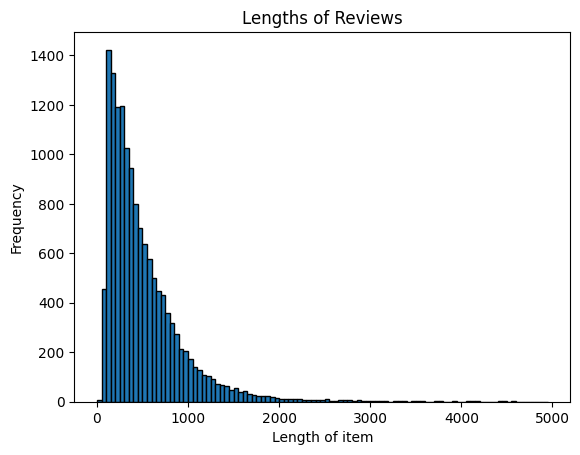

In [ ]:
lengths = [len(item) for item in text_data]

plt.hist(lengths, edgecolor='black', bins=np.arange(0, 5000, 50))

plt.xlabel('Length of item')
plt.ylabel('Frequency')
plt.title('Lengths of Reviews')

plt.show()

By the distribution, we see that setting the length to 2000 would allow most reviews to stay complete while avoiding too long vectors, to not over complicate the models.

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

texts = [text for text in df['review_text']]
print(f'There are {len(texts)} review texts in the dataset.')
maxlen = 2000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('In these texts, there are %s unique tokens.' % len(word_index))

There are 14500 review texts in the dataset.
In these texts, there are 23978 unique tokens.


In [ ]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Define embedding matrix for the model
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [ ]:
# Vectorizing the training text data, here for embedding

text_vectorization = keras.layers.TextVectorization(max_tokens = 8000, output_mode="int", output_sequence_length=2000, ngrams=(2,1))
text_vectorization.adapt(text_data)

print(text_train.shape)
text_train_v = text_vectorization(text_train)
print(text_train_v.shape)
text_train_v = pad_sequences(text_train_v, maxlen=maxlen)
print(text_train_v.shape)

(11600,)
(11600, 2000)
(11600, 2000)


In [ ]:
# And the test text data
print(text_test.shape)
text_test_v = text_vectorization(text_test)
print(text_test_v.shape)
text_test_v = pad_sequences(text_test_v, maxlen=maxlen)
print(text_test_v.shape)

(2900,)
(2900, 2000)
(2900, 2000)


## Model 3 - CNN with GloVe embeddings

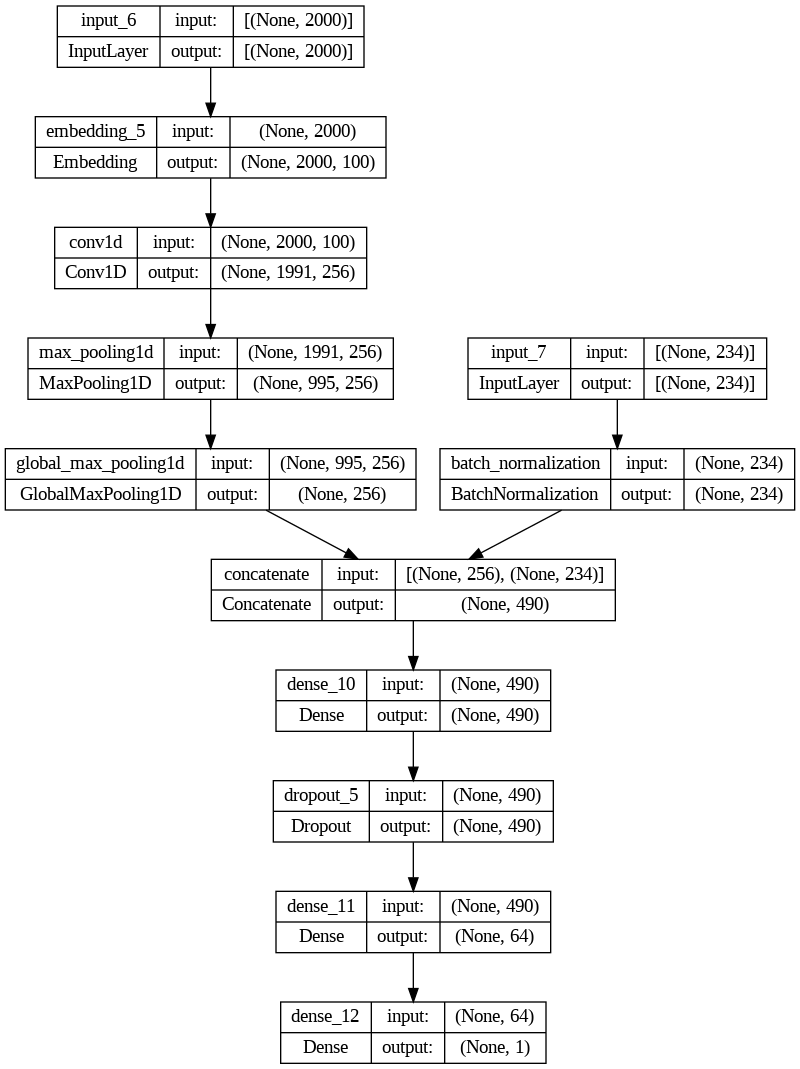

In [ ]:
# Import necessary layers for CNN
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

maxlen = 2000
max_words = 10000

def build_cnn():
  learning_rate = 0.0002

  # Define input layers
  text_input = Input(shape=(maxlen,))
  other_input = Input(shape=(other_data.shape[1],))

  embedding_layer = Embedding(max_words, embedding_dim, input_length=maxlen,
                              weights=[embedding_matrix], mask_zero=True)
  embedding_layer.trainable = False

  # Apply embedding layer to text input
  embedded_text = embedding_layer(text_input)

  # Add Convolutional Layer
  filters = 256
  kernel_size = 10
  convolved_text = Conv1D(filters, kernel_size, activation='relu')(embedded_text)

  # Add MaxPooling Layer
  pool_size = 2
  max_pooled_text = MaxPooling1D(pool_size)(convolved_text)

  # Add Global MaxPooling Layer
  global_max_pooled_text = GlobalMaxPooling1D()(max_pooled_text)

  # Apply normalization layer to other input
  normalized_other = BatchNormalization()(other_input)

  # Concatenate text and other inputs
  concatenated = concatenate([global_max_pooled_text, normalized_other])

  dense = concatenated
  dense_layers = 1
  dense_units = dense.shape[1]
  # dense = Dense(dense_units, activation='relu')(dense)
  for i in range(dense_layers):
      dense = Dense(dense_units
                    // 2**i
                    , activation='relu'
      , kernel_regularizer='l1'
      )(dense)
      dense = Dropout(0.5)(dense)
  dense = Dense(64, activation='relu')(dense)
  output = Dense(1, activation='sigmoid')(dense)

  optimizer = Adam(
      learning_rate = learning_rate
      )

  # Define and compile model
  model = Model(inputs=[text_input, other_input], outputs=output)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
model = build_cnn()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# Define number of folds for cross-validation
n_folds = 3

# Define cross-validation split
kfold = KFold(n_splits=n_folds, shuffle=True, random_state = 0)

# Train model using cross-validation
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []
num_epochs = 20

for fold, (train_idx, val_idx) in enumerate(kfold.split(text_train_v, other_train, y_class_train)):
    print(f"Fold {fold+1}:")
    # Get train and validation data for this fold
    text_train_fold, other_train_fold, y_train_fold = text_train_v[train_idx], other_train[train_idx], y_class_train[train_idx]
    text_val_fold, other_val_fold, y_val_fold = text_train_v[val_idx], other_train[val_idx], y_class_train[val_idx]
    model = build_cnn()
    # Train model for this fold
    history = model.fit([text_train_fold, other_train_fold], y_train_fold, epochs=num_epochs, batch_size=32,
                        validation_data=([text_val_fold, other_val_fold], y_val_fold), class_weight=class_weights, verbose=1)
    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    acc_history = history.history['accuracy']
    val_history = history.history['val_accuracy']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_history)

Fold 1:
Epoch 1/20
242/242 [==============================] - 77s 315ms/step - loss: 49.9852 - accuracy: 0.5822 - val_loss: 16.0791 - val_accuracy: 0.5712
Epoch 2/20
242/242 [==============================] - 77s 319ms/step - loss: 4.4236 - accuracy: 0.6258 - val_loss: 0.8312 - val_accuracy: 0.5782
Epoch 3/20
242/242 [==============================] - 82s 339ms/step - loss: 0.7746 - accuracy: 0.6322 - val_loss: 0.7740 - val_accuracy: 0.6731
Epoch 4/20
242/242 [==============================] - 75s 309ms/step - loss: 0.7567 - accuracy: 0.6387 - val_loss: 0.7521 - val_accuracy: 0.6080
Epoch 5/20
242/242 [==============================] - 74s 304ms/step - loss: 0.7439 - accuracy: 0.6445 - val_loss: 0.7514 - val_accuracy: 0.6362
Epoch 6/20
242/242 [==============================] - 75s 309ms/step - loss: 0.7347 - accuracy: 0.6524 - val_loss: 0.7406 - val_accuracy: 0.6871
Epoch 7/20
242/242 [==============================] - 75s 308ms/step - loss: 0.7341 - accuracy: 0.6578 - val_loss: 0.733

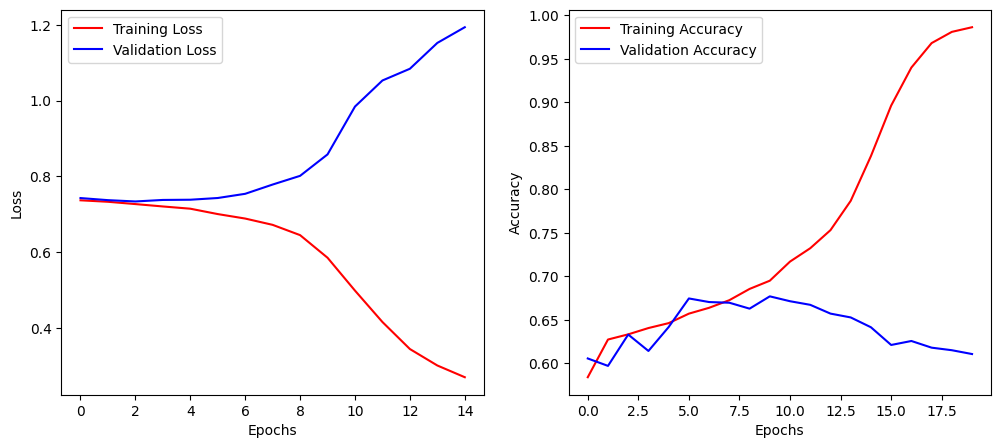

In [ ]:
# plotting the loss and accuracy side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss performance
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
axs[0].plot(average_loss_history[5:], c='r')
axs[0].plot( average_val_loss_history[5:], c='b')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training Loss','Validation Loss'])

# Plot accuracy performance
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
axs[1].plot(average_acc_history,c='r')
axs[1].plot(average_val_acc_history,c='b')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(['Training Accuracy','Validation Accuracy'])

plt.show()

In [ ]:
from keras.models import load_model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model = build_cnn()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="cnn.tf",
                                    save_best_only=True, monitor="val_accuracy")
]

model.fit([text_train_v, other_train], y_class_train,epochs=10,batch_size=32
          ,validation_split=0.2
          , callbacks=callbacks
          ,class_weight=class_weights
          )

model = load_model("cnn.tf")
test_acc = model.evaluate([text_test_v, other_test], y_class_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

Epoch 1/10
290/290 [==============================] - ETA: 0s - loss: 44.4625 - accuracy: 0.5938

290/290 [==============================] - 86s 292ms/step - loss: 44.4625 - accuracy: 0.5938 - val_loss: 9.3834 - val_accuracy: 0.5966
Epoch 2/10
290/290 [==============================] - ETA: 0s - loss: 2.2771 - accuracy: 0.6355

290/290 [==============================] - 84s 291ms/step - loss: 2.2771 - accuracy: 0.6355 - val_loss: 0.8261 - val_accuracy: 0.6004
Epoch 3/10
290/290 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.6395

290/290 [==============================] - 84s 290ms/step - loss: 0.7789 - accuracy: 0.6395 - val_loss: 0.7687 - val_accuracy: 0.6047
Epoch 4/10
290/290 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.6450

290/290 [==============================] - 84s 289ms/step - loss: 0.7473 - accuracy: 0.6450 - val_loss: 0.7538 - val_accuracy: 0.6474
Epoch 5/10
290/290 [==============================] - ETA: 0s - loss: 0.7391 - accuracy: 0.6508

290/290 [==============================] - 84s 291ms/step - loss: 0.7391 - accuracy: 0.6508 - val_loss: 0.7442 - val_accuracy: 0.6522
Epoch 6/10
290/290 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.6619

290/290 [==============================] - 84s 291ms/step - loss: 0.7291 - accuracy: 0.6619 - val_loss: 0.7561 - val_accuracy: 0.6772
Epoch 7/10
290/290 [==============================] - 83s 287ms/step - loss: 0.7258 - accuracy: 0.6719 - val_loss: 0.7387 - val_accuracy: 0.6724
Epoch 8/10
290/290 [==============================] - 83s 286ms/step - loss: 0.7218 - accuracy: 0.6837 - val_loss: 0.7320 - val_accuracy: 0.6591
Epoch 9/10
290/290 [==============================] - 83s 285ms/step - loss: 0.7163 - accuracy: 0.6891 - val_loss: 0.7335 - val_accuracy: 0.6759
Epoch 10/10
91/91 [==============================] - 7s 74ms/step - loss: 0.7531 - accuracy: 0.6769
The resulting model is about 67.69% accurate in the holdout sample.


##Model 4 - RNN with Glove embeddings - classification

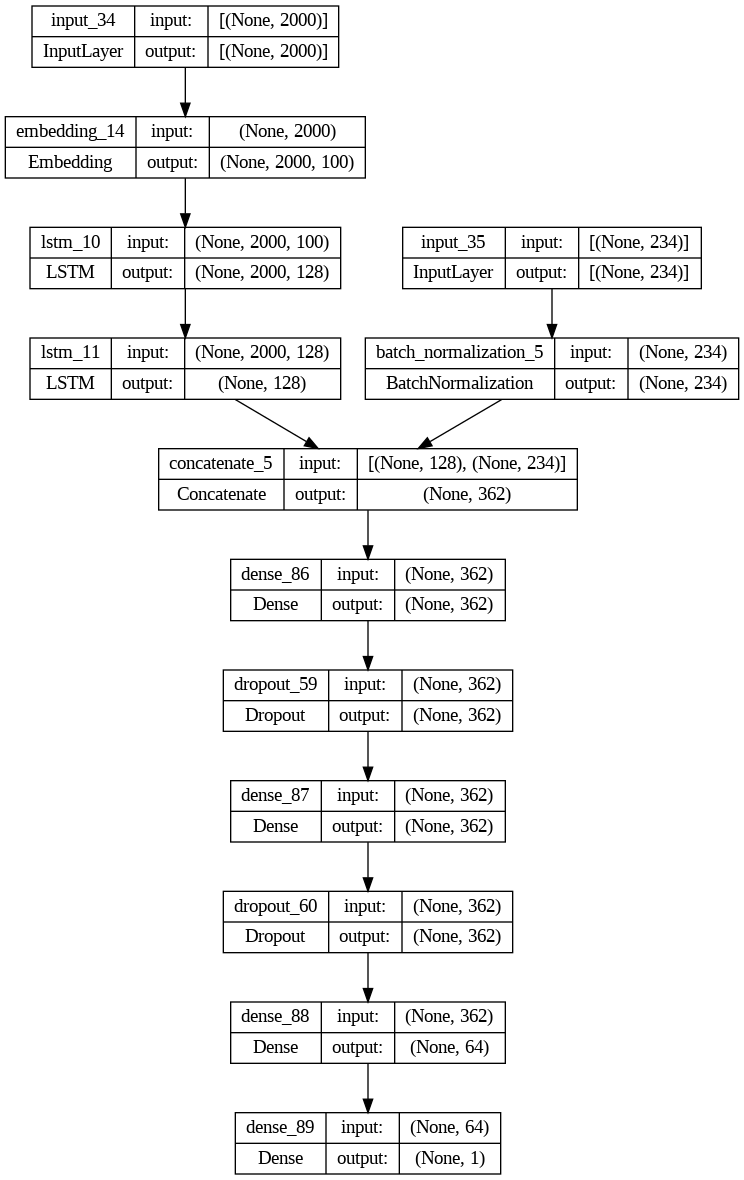

In [ ]:
from keras.layers import LSTM, Dropout

def build_rnn():
  learning_rate = 0.002
  # Define input layers
  text_input = Input(shape=(maxlen,))
  other_input = Input(shape=(other_data.shape[1],))

  embedding_layer = Embedding(max_words, embedding_dim, input_length=maxlen,
                              weights=[embedding_matrix], mask_zero=True)
  embedding_layer.trainable = False

  # Apply embedding layer to text input
  embedded_text = embedding_layer(text_input)

  # Add LSTM Layer
  lstm_units = 128
  lstm_layer = LSTM(lstm_units, recurrent_dropout=0.5, return_sequences=True)(embedded_text)
  lstm_layer = LSTM(lstm_units, recurrent_dropout=0.5)(lstm_layer)

  # Apply normalization layer to other input
  normalized_other = BatchNormalization()(other_input)

  # Concatenate text and other inputs
  concatenated = concatenate([lstm_layer, normalized_other])

  dense = concatenated
  dense_layers = 1
  dense_units = dense.shape[1]
  dense = Dense(dense_units, activation='relu', kernel_regularizer='l1')(dense)
  dense = Dropout(0.5)(dense)
  for i in range(dense_layers):
      dense = Dense(dense_units // 2**i, activation='relu')(dense)
      dense = Dropout(0.5)(dense)
  dense = Dense(64, activation='relu')(dense)
  output = Dense(1, activation='sigmoid')(dense)

  optimizer = Adam(
      # learning_rate = learning_rate
      )
  # Define and compile model
  model = Model(inputs=[text_input, other_input], outputs=output)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = build_rnn()
keras.utils.plot_model(model,show_shapes=True)


In [ ]:
# Define number of folds for cross-validation
n_folds = 3

# Define cross-validation split
kfold = KFold(n_splits=n_folds, shuffle=True, random_state = 1)

# Train model using cross-validation
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []
num_epochs = 20
for fold, (train_idx, val_idx) in enumerate(kfold.split(text_train_v, other_train, y_class_train)):
    print(f"Fold {fold+1}:")
    # Get train and validation data for this fold
    text_train_fold, other_train_fold, y_train_fold = text_train_v[train_idx], other_train[train_idx], y_class_train[train_idx]
    text_val_fold, other_val_fold, y_val_fold = text_train_v[val_idx], other_train[val_idx], y_class_train[val_idx]
    model = build_rnn()
    # Train model for this fold
    history = model.fit([text_train_fold, other_train_fold], y_train_fold, epochs=num_epochs, batch_size=64,
                        validation_data=([text_val_fold, other_val_fold], y_val_fold),class_weight=class_weights, verbose=1)
    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    acc_history = history.history['accuracy']
    val_history = history.history['val_accuracy']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_history)

Fold 1:
Epoch 1/20
121/121 [==============================] - 100s 766ms/step - loss: 16.5600 - accuracy: 0.5749 - val_loss: 0.9445 - val_accuracy: 0.5875
Epoch 2/20
121/121 [==============================] - 89s 739ms/step - loss: 0.9558 - accuracy: 0.6388 - val_loss: 0.9492 - val_accuracy: 0.6605
Epoch 3/20
121/121 [==============================] - 89s 739ms/step - loss: 0.9527 - accuracy: 0.6525 - val_loss: 0.9249 - val_accuracy: 0.6739
Epoch 4/20
121/121 [==============================] - 89s 740ms/step - loss: 0.9316 - accuracy: 0.6607 - val_loss: 0.9226 - val_accuracy: 0.6553
Epoch 5/20
121/121 [==============================] - 89s 738ms/step - loss: 0.9191 - accuracy: 0.6627 - val_loss: 0.9229 - val_accuracy: 0.6509
Epoch 6/20
121/121 [==============================] - 89s 739ms/step - loss: 0.9158 - accuracy: 0.6653 - val_loss: 0.9152 - val_accuracy: 0.6488
Epoch 7/20
121/121 [==============================] - 89s 740ms/step - loss: 0.8978 - accuracy: 0.6585 - val_loss: 0.904

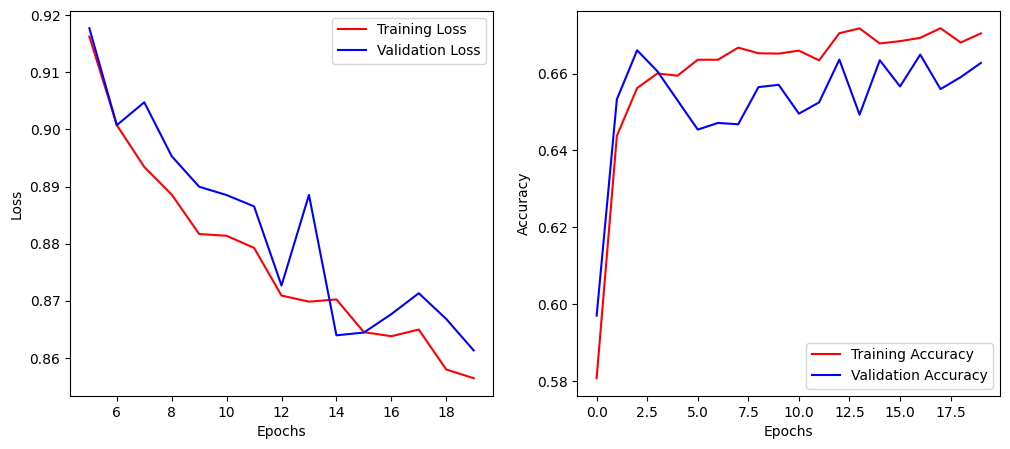

In [ ]:
# plotting the loss and accuracy side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss performance
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
axs[0].plot(range(5, num_epochs), average_loss_history[5:], c='r')
axs[0].plot(range(5, num_epochs), average_val_loss_history[5:], c='b')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training Loss','Validation Loss'])

# Plot accuracy performance
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
axs[1].plot(average_acc_history,c='r')
axs[1].plot(average_val_acc_history,c='b')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(['Training Accuracy','Validation Accuracy'])

plt.show()

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model = build_rnn()
# model.fit([text_train_v, other_train], y_class_train,epochs=25,batch_size=16)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="rnn",
                                    save_best_only=True, monitor="val_accuracy")
]

model.fit([text_train_v, other_train], y_class_train,epochs=20,batch_size=32,validation_split=0.2, callbacks=callbacks,class_weight=class_weights, verbose=1)


Epoch 1/20
290/290 [==============================] - ETA: 0s - loss: 7.4817 - accuracy: 0.6306

290/290 [==============================] - 150s 503ms/step - loss: 7.4817 - accuracy: 0.6306 - val_loss: 0.9820 - val_accuracy: 0.6560
Epoch 2/20
290/290 [==============================] - 137s 474ms/step - loss: 0.9642 - accuracy: 0.6538 - val_loss: 0.9722 - val_accuracy: 0.6319
Epoch 3/20
290/290 [==============================] - 144s 498ms/step - loss: 0.9332 - accuracy: 0.6645 - val_loss: 0.9067 - val_accuracy: 0.6358
Epoch 4/20
290/290 [==============================] - 151s 521ms/step - loss: 0.8975 - accuracy: 0.6671 - val_loss: 0.9075 - val_accuracy: 0.6341
Epoch 5/20
290/290 [==============================] - 144s 495ms/step - loss: 0.8880 - accuracy: 0.6567 - val_loss: 0.8969 - val_accuracy: 0.6491
Epoch 6/20
290/290 [==============================] - 139s 480ms/step - loss: 0.8797 - accuracy: 0.6667 - val_loss: 0.8965 - val_accuracy: 0.6440
Epoch 7/20
290/290 [==============================] - 136s 470ms/step - loss: 0.8748 - accuracy: 0.6584 - val_loss: 0.8751 - val_accura

290/290 [==============================] - 151s 521ms/step - loss: 0.8637 - accuracy: 0.6719 - val_loss: 0.8630 - val_accuracy: 0.6616
Epoch 9/20
290/290 [==============================] - 139s 481ms/step - loss: 0.8607 - accuracy: 0.6613 - val_loss: 0.8636 - val_accuracy: 0.6470
Epoch 10/20
290/290 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.6659

290/290 [==============================] - 150s 516ms/step - loss: 0.8572 - accuracy: 0.6659 - val_loss: 0.8614 - val_accuracy: 0.6685
Epoch 11/20
290/290 [==============================] - 144s 497ms/step - loss: 0.8575 - accuracy: 0.6697 - val_loss: 0.8645 - val_accuracy: 0.6556
Epoch 12/20
290/290 [==============================] - 144s 495ms/step - loss: 0.8546 - accuracy: 0.6711 - val_loss: 0.8777 - val_accuracy: 0.6272
Epoch 13/20
290/290 [==============================] - 142s 488ms/step - loss: 0.8579 - accuracy: 0.6697 - val_loss: 0.8704 - val_accuracy: 0.6573
Epoch 14/20
290/290 [==============================] - 144s 497ms/step - loss: 0.8513 - accuracy: 0.6724 - val_loss: 0.8683 - val_accuracy: 0.6608
Epoch 15/20
290/290 [==============================] - 144s 496ms/step - loss: 0.8570 - accuracy: 0.6653 - val_loss: 0.8671 - val_accuracy: 0.6655
Epoch 16/20
290/290 [==============================] - 143s 493ms/step - loss: 0.8560 - accuracy: 0.6693 - val_loss: 0.8783 - val_

NameError: ignored

In [ ]:
from keras.models import load_model
model = load_model("rnn")

test_acc = model.evaluate([text_test_v, other_test], y_class_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

91/91 [==============================] - 9s 91ms/step - loss: 0.8762 - accuracy: 0.6497
The resulting model is about 64.97% accurate in the holdout sample.


## Model 5 - Attention

Next is an attention model with only the text data, using the example code from class.

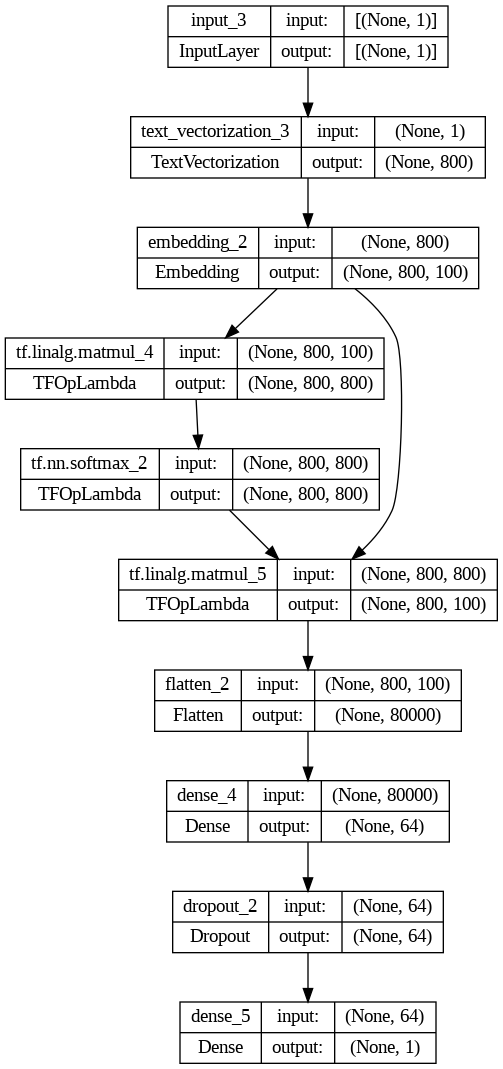

In [ ]:
text_vectorization = keras.layers.TextVectorization(max_tokens = 1000, output_mode="int", output_sequence_length=800)
text_vectorization.adapt(text_data)

def build_scaled_dotprod_model():

    inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

    integer_seqs = text_vectorization(inputs)
    embeddings = layers.Embedding(1000,100)(integer_seqs)
    pairwise_dot_products = tf.matmul(embeddings, embeddings, transpose_b=True)

    attention_weights = tf.nn.softmax(pairwise_dot_products, axis=-1)

    attention_output = tf.matmul(attention_weights, embeddings)

    # Flatten the attention output
    attention_output = layers.Flatten()(attention_output)
    x = layers.Dense(64, activation = 'relu', kernel_regularizer='l1')(attention_output)
    x = layers.Dropout(0.5)(x)
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
model = build_scaled_dotprod_model()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
from keras.models import load_model
model = build_scaled_dotprod_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="dotprod.tf",
                                    save_best_only=True, monitor="val_accuracy")
]

history = model.fit(text_train, y_class_train,
                        validation_split=0.2,
                        epochs=15, batch_size=32,callbacks=callbacks, class_weight=class_weights)

model = load_model("dotprod.tf")
print(f"Test acc: {model.evaluate(text_test,y_class_test)[1]:.2f}")

Epoch 1/15
290/290 [==============================] - ETA: 0s - loss: 11.4827 - accuracy: 0.5667

290/290 [==============================] - 42s 142ms/step - loss: 11.4827 - accuracy: 0.5667 - val_loss: 6.7445 - val_accuracy: 0.5776
Epoch 2/15
290/290 [==============================] - ETA: 0s - loss: 6.7495 - accuracy: 0.5707

290/290 [==============================] - 40s 139ms/step - loss: 6.7495 - accuracy: 0.5707 - val_loss: 6.8111 - val_accuracy: 0.5991
Epoch 3/15
290/290 [==============================] - ETA: 0s - loss: 6.9522 - accuracy: 0.6134

290/290 [==============================] - 41s 140ms/step - loss: 6.9522 - accuracy: 0.6134 - val_loss: 6.9585 - val_accuracy: 0.6297
Epoch 4/15
290/290 [==============================] - 39s 134ms/step - loss: 6.9956 - accuracy: 0.6131 - val_loss: 7.0007 - val_accuracy: 0.5720
Epoch 5/15
290/290 [==============================] - 39s 134ms/step - loss: 6.9831 - accuracy: 0.6193 - val_loss: 6.9458 - val_accuracy: 0.6259
Epoch 6/15
290/290 [==============================] - ETA: 0s - loss: 6.9999 - accuracy: 0.6158

290/290 [==============================] - 40s 138ms/step - loss: 6.9999 - accuracy: 0.6158 - val_loss: 7.0381 - val_accuracy: 0.6474
Epoch 7/15
290/290 [==============================] - 40s 137ms/step - loss: 7.0364 - accuracy: 0.6254 - val_loss: 6.9847 - val_accuracy: 0.6409
Epoch 8/15
290/290 [==============================] - 40s 138ms/step - loss: 7.0254 - accuracy: 0.6273 - val_loss: 6.9918 - val_accuracy: 0.6039
Epoch 9/15
290/290 [==============================] - ETA: 0s - loss: 7.0605 - accuracy: 0.6315

290/290 [==============================] - 41s 141ms/step - loss: 7.0605 - accuracy: 0.6315 - val_loss: 7.0852 - val_accuracy: 0.6496
Epoch 10/15
290/290 [==============================] - 39s 134ms/step - loss: 7.1399 - accuracy: 0.6401 - val_loss: 7.0346 - val_accuracy: 0.6375
Epoch 11/15
290/290 [==============================] - 39s 134ms/step - loss: 7.1322 - accuracy: 0.6392 - val_loss: 7.1023 - val_accuracy: 0.6461
Epoch 12/15
290/290 [==============================] - 39s 134ms/step - loss: 7.1854 - accuracy: 0.6483 - val_loss: 7.1241 - val_accuracy: 0.6371
Epoch 13/15
290/290 [==============================] - 39s 134ms/step - loss: 7.2065 - accuracy: 0.6438 - val_loss: 7.2070 - val_accuracy: 0.6228
Epoch 14/15
290/290 [==============================] - 39s 136ms/step - loss: 7.2659 - accuracy: 0.6444 - val_loss: 7.2548 - val_accuracy: 0.6142
Epoch 15/15
91/91 [==============================] - 4s 47ms/step - loss: 7.0899 - accuracy: 0.6438
Test acc: 0.64


#3. Categorical Classification

Next, I will try to predict a more accurate value of the score, by dividing the count into 4 values/ranges: 0, 1, 1-10, +10

In [ ]:
bins = [-0.01,0.99,1.1,10,1000]
df['cat_label'] = pd.cut(df['review_isUsefulCount'], bins=bins, labels=[0,1,5,10])
df['cat_label'].describe()

count     14500
unique        4
top           0
freq       8210
Name: cat_label, dtype: int64

In [ ]:
# creating an array of 4 dummy variables for the prediction target
one_hot = pd.get_dummies(df['cat_label'])

# concatenate the one-hot encoded column with the original DataFrame
df_encoded = pd.concat([df, one_hot], axis=1)

# remove the original categorical column
df_encoded = df_encoded.drop('cat_label', axis=1)
cat_labels = one_hot.values

#getting the weights
total_samples = len(cat_labels)
cat_class_weights = {}
for col_idx in range(cat_labels.shape[1]):
    col = cat_labels[:, col_idx]
    cat_class_weights[col_idx] = total_samples / (2 * col.sum())

print(cat_labels)
print(cat_class_weights)


[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]
{0: 0.8830694275274056, 1: 2.245972738537794, 2: 2.5, 3: 44.75308641975309}


In [ ]:
# shuffle the indices
shuffled_indices = np.random.permutation(len(df))

# split the indices into training and testing sets
train_indices = shuffled_indices[:int(0.8*len(shuffled_indices))]
test_indices = shuffled_indices[int(0.8*len(shuffled_indices)):]

# split the data using the indices
text_data = df['review_text'].to_numpy()
other_data = df.drop(['review_isCoolCount' ,'review_isFunnyCount', 'review_isUsefulCount','review_text','cat_label'], axis=1).values

text_train = text_data[train_indices]
other_train = other_data[train_indices]
y_cat_train = cat_labels[train_indices]

text_test = text_data[test_indices]
other_test = other_data[test_indices]
y_cat_test = cat_labels[test_indices]

for i in [text_train, other_train, y_cat_train, text_test, other_test, y_cat_test ]:
  print(i.shape)

(11600,)
(11600, 234)
(11600, 4)
(2900,)
(2900, 234)
(2900, 4)


###Dummy Model

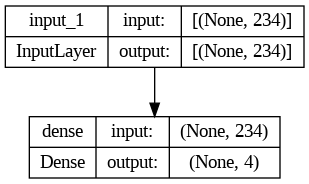

In [ ]:
def dummy_cat():
    inputs = keras.Input(shape=(other_train.shape[1],), dtype = "float32")
    x = keras.layers.Dense(4, activation="softmax")(inputs)
    model = keras.Model(inputs, x)
    model.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])
    return model
model = dummy_cat()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model = dummy_cat()
model.fit( other_train, y_cat_train, batch_size=32, class_weight = cat_class_weights, verbose=1)

test_acc = model.evaluate( other_test, y_cat_test)[1]
print(f'The resulting model has about {test_acc:.2f} accuracy in the holdout sample.')

91/91 [==============================] - 0s 894us/step - loss: 1.0021 - accuracy: 0.5734
The resulting model has about 0.57 accuracy in the holdout sample.


### CNN Model

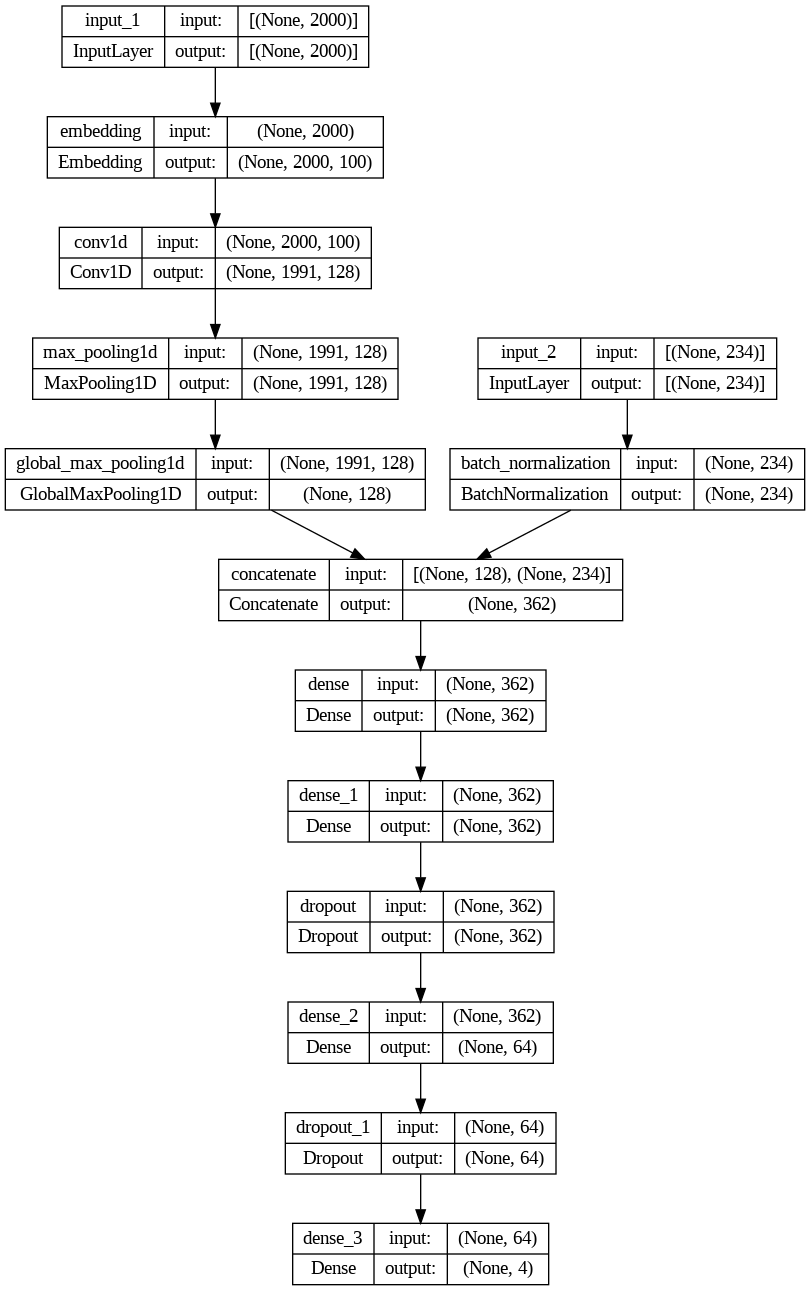

In [ ]:
# Import necessary layers for CNN
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import backend as K

def build_cnn_cat():
  learning_rate = 0.004  # set the learning rate

  # Define input layers
  text_input = Input(shape=(maxlen,))
  other_input = Input(shape=(other_data.shape[1],))

  embedding_layer = Embedding(max_words, embedding_dim, input_length=maxlen,
                              weights=[embedding_matrix], mask_zero=True)
  embedding_layer.trainable = False

  # Apply embedding layer to text input
  embedded_text = embedding_layer(text_input)

  # Add Convolutional Layer
  filters = 128
  kernel_size = 10
  convolved_text = Conv1D(filters, kernel_size, activation='relu')(embedded_text)

  # Add MaxPooling Layer
  pool_size = 1
  max_pooled_text = MaxPooling1D(pool_size)(convolved_text)

  # Add Global MaxPooling Layer
  global_max_pooled_text = GlobalMaxPooling1D()(max_pooled_text)

  # Apply normalization layer to other input
  normalized_other = BatchNormalization()(other_input)

  # Concatenate text and other inputs
  concatenated = concatenate([global_max_pooled_text, normalized_other])

  dense = concatenated
  dense_layers = 1
  dense_units = dense.shape[1]
  dense = Dense(dense_units, activation='relu')(dense)
  for i in range(dense_layers):
      dense = Dense(dense_units // 2**i, activation='relu'
      , kernel_regularizer='l1'
      )(dense)
      dense = Dropout(0.5)(dense)
  dense = Dense(64, activation='relu')(dense)
  dense = Dropout(0.5)(dense)

  output = Dense(4, activation='softmax')(dense)

  model = Model(inputs=[text_input, other_input], outputs=output)

# Compile model with weighted loss function and relu activation
  model.compile(optimizer='rmsprop', loss='CategoricalCrossentropy', metrics=['accuracy'])

  return model
model = build_cnn_cat()
keras.utils.plot_model(model,show_shapes=True)


In [ ]:
from keras import backend as K

# Define number of folds for cross-validation
n_folds = 3

# Define cross-validation split
kfold = KFold(n_splits=n_folds, shuffle=True, random_state = 1)

# Train model using cross-validation
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []
num_epochs = 20

for fold, (train_idx, val_idx) in enumerate(kfold.split(text_train_v, other_train, y_cat_train)):
    print(f"Fold {fold+1}:")
    # Get train and validation data for this fold
    text_train_fold, other_train_fold, y_train_fold = text_train_v[train_idx], other_train[train_idx], y_cat_train[train_idx]
    text_val_fold, other_val_fold, y_val_fold = text_train_v[val_idx], other_train[val_idx], y_cat_train[val_idx]
    model = build_cnn_cat()
    # Train model for this fold

    history = model.fit([text_train_fold, other_train_fold], y_train_fold, epochs=num_epochs, batch_size=128,
                    validation_data=([text_val_fold, other_val_fold], y_val_fold), verbose=1, class_weight = cat_class_weights
                    )

    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    acc_history = history.history['accuracy']
    val_history = history.history['val_accuracy']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_history)


Fold 1:
Epoch 1/20
61/61 [==============================] - 34s 540ms/step - loss: 25.6699 - accuracy: 0.5329 - val_loss: 5.7848 - val_accuracy: 0.5674
Epoch 2/20
61/61 [==============================] - 33s 544ms/step - loss: 2.4103 - accuracy: 0.5649 - val_loss: 1.7319 - val_accuracy: 0.5674
Epoch 3/20
61/61 [==============================] - 33s 535ms/step - loss: 1.7225 - accuracy: 0.5650 - val_loss: 1.7106 - val_accuracy: 0.5674
Epoch 4/20
61/61 [==============================] - 33s 537ms/step - loss: 1.7003 - accuracy: 0.5650 - val_loss: 1.6866 - val_accuracy: 0.5674
Epoch 5/20
61/61 [==============================] - 32s 534ms/step - loss: 1.6755 - accuracy: 0.5650 - val_loss: 1.6693 - val_accuracy: 0.5674
Epoch 6/20
61/61 [==============================] - 33s 535ms/step - loss: 1.6449 - accuracy: 0.5650 - val_loss: 1.6640 - val_accuracy: 0.5674
Epoch 7/20
61/61 [==============================] - 33s 538ms/step - loss: 1.6171 - accuracy: 0.5694 - val_loss: 1.7116 - val_accurac

In [ ]:
from keras.models import load_model
model = build_cnn_cat()

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="cnn_cat",
                                    save_best_only=True, monitor="val_accuracy")
]
model.fit([text_train_v, other_train], y_cat_train,epochs=10, batch_size=32,validation_split=0.2, class_weight = cat_class_weights, callbacks=callbacks)
model = load_model("cnn_cat")
test_acc = model.evaluate([text_test_v, other_test], y_cat_test)[1]
print(f'The resulting model has about {test_acc:.2f} accuracy in the holdout sample.')

Epoch 1/10
290/290 [==============================] - ETA: 0s - loss: 11.2743 - accuracy: 0.3508

290/290 [==============================] - 264s 905ms/step - loss: 11.2743 - accuracy: 0.3508 - val_loss: 2.0038 - val_accuracy: 0.5776
Epoch 2/10
290/290 [==============================] - 273s 943ms/step - loss: 3.7044 - accuracy: 0.3856 - val_loss: 2.2176 - val_accuracy: 0.4784
Epoch 3/10
290/290 [==============================] - 256s 880ms/step - loss: 3.6457 - accuracy: 0.3682 - val_loss: 2.1681 - val_accuracy: 0.4677
Epoch 4/10
290/290 [==============================] - ETA: 0s - loss: 3.5938 - accuracy: 0.3494

290/290 [==============================] - 259s 892ms/step - loss: 3.5938 - accuracy: 0.3494 - val_loss: 1.8877 - val_accuracy: 0.5815
Epoch 5/10
290/290 [==============================] - 255s 876ms/step - loss: 3.5492 - accuracy: 0.3698 - val_loss: 2.2468 - val_accuracy: 0.3224
Epoch 6/10
290/290 [==============================] - 272s 939ms/step - loss: 3.3827 - accuracy: 0.3750 - val_loss: 2.0201 - val_accuracy: 0.4901
Epoch 7/10
290/290 [==============================] - 253s 873ms/step - loss: 3.2061 - accuracy: 0.4267 - val_loss: 1.8340 - val_accuracy: 0.5759
Epoch 8/10
290/290 [==============================] - 281s 968ms/step - loss: 3.0846 - accuracy: 0.4332 - val_loss: 1.9345 - val_accuracy: 0.5267
Epoch 9/10
290/290 [==============================] - 281s 971ms/step - loss: 2.9285 - accuracy: 0.4547 - val_loss: 1.8988 - val_accuracy: 0.5371
Epoch 10/10
91/91 [==============================] - 28s 307ms/step - loss: 1.8991 - accuracy: 0.5579
The resulting model has about 0.5

# 4. Multiple Outputs Binary Classification

In [ ]:
# setting the labels to be the review "useful", "funny", or "cool" counts
labels_use = np.asarray(df['review_isUsefulCount'])
labels_funny = np.asarray(df['review_isFunnyCount'])
labels_cool = np.asarray(df['review_isCoolCount'])

# shuffle the indices
shuffled_indices = np.random.permutation(len(df))

# split the indices into training and testing sets
train_indices = shuffled_indices[:int(0.8*len(shuffled_indices))]
test_indices = shuffled_indices[int(0.8*len(shuffled_indices)):]

# split the data using the indices
text_data = df['review_text'].to_numpy()
other_data = df.drop(['review_isCoolCount' ,'review_isFunnyCount', 'review_isUsefulCount','review_text'], axis=1).values
labels_use_classification = (labels_use > 0).astype(int)
labels_funny_classification = (labels_funny > 0).astype(int)
labels_cool_classification = (labels_cool > 0).astype(int)

text_train = text_data[train_indices]
other_train = other_data[train_indices]
y_use_train = labels_use_classification[train_indices]
y_cool_train = labels_funny_classification[train_indices]
y_fun_train= labels_cool_classification[train_indices]

text_test = text_data[test_indices]
other_test = other_data[test_indices]
y_use_test = labels_use_classification[test_indices]
y_cool_test = labels_funny_classification[test_indices]
y_fun_test= labels_cool_classification[test_indices]


In [ ]:
#class imbalance for funny and cool

funny_weights = {0: total_samples / (2 * np.sum(labels_funny_classification == 0)),
                 1: total_samples / (2 * np.sum(labels_funny_classification == 1))}
cool_weights = {0: total_samples / (2 * np.sum(labels_cool_classification == 0)),
                 1: total_samples / (2 * np.sum(labels_cool_classification == 1))}

In [ ]:
#vectorizing the text
text_train_v = text_vectorization(text_train)
text_train_v = pad_sequences(text_train_v, maxlen=maxlen)

text_test_v = text_vectorization(text_test)
text_test_v = pad_sequences(text_test_v, maxlen=maxlen)

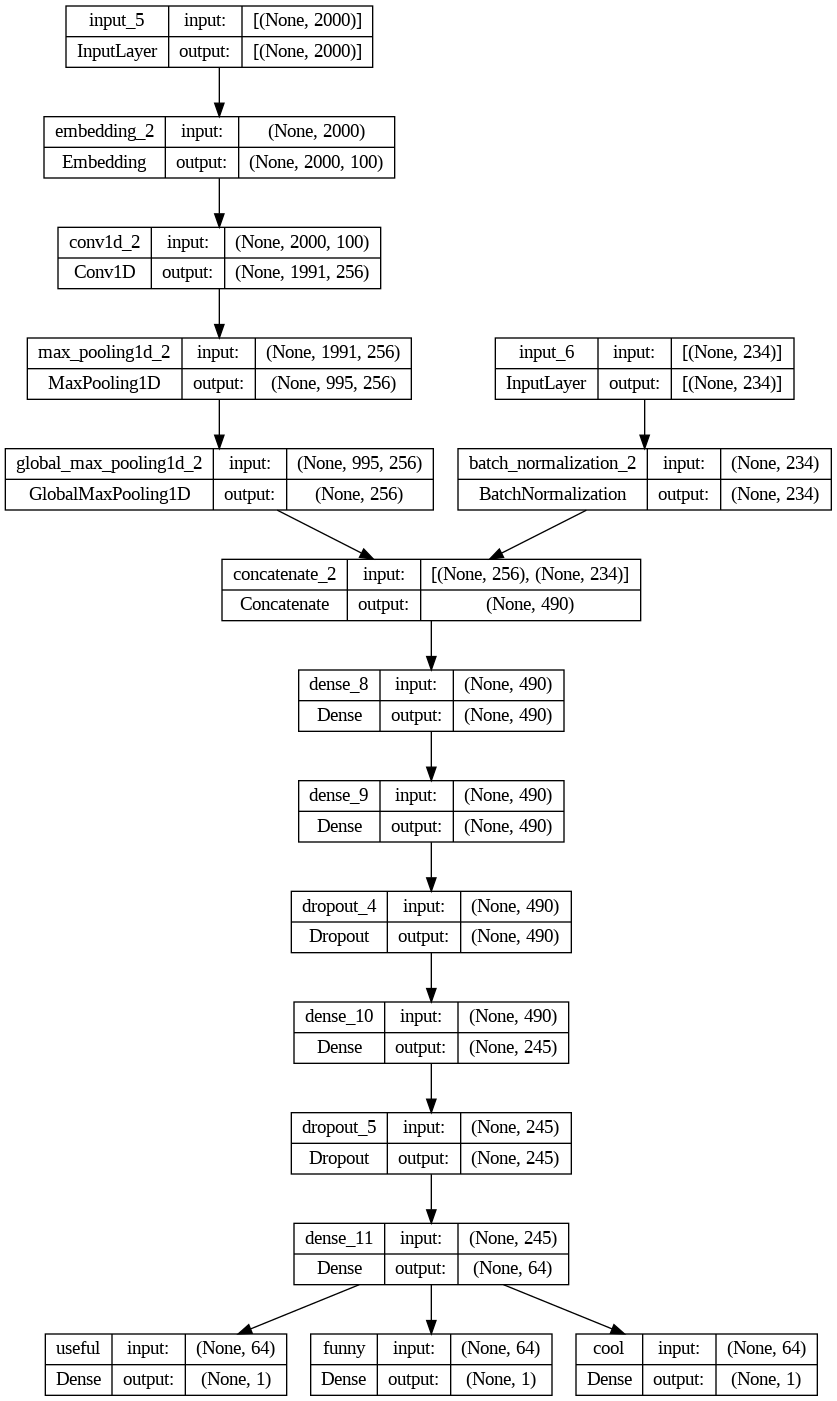

In [ ]:
# Import necessary layers for CNN
import keras.backend as K

from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
def multi_cnn():
  learning_rate = 0.0002  # set the learning rate

  # Define input layers
  text_input = Input(shape=(maxlen,))
  other_input = Input(shape=(other_data.shape[1],))

  embedding_layer = Embedding(max_words, embedding_dim, input_length=maxlen,
                              weights=[embedding_matrix], mask_zero=True)
  embedding_layer.trainable = False

  # Apply embedding layer to text input
  embedded_text = embedding_layer(text_input)

  # Add Convolutional Layer
  filters = 256
  kernel_size = 10
  convolved_text = Conv1D(filters, kernel_size, activation='relu')(embedded_text)

  # Add MaxPooling Layer
  pool_size = 2
  max_pooled_text = MaxPooling1D(pool_size)(convolved_text)

  # Add Global MaxPooling Layer
  global_max_pooled_text = GlobalMaxPooling1D()(max_pooled_text)

  # Apply normalization layer to other input
  normalized_other = BatchNormalization()(other_input)

  # Concatenate text and other inputs
  concatenated = concatenate([global_max_pooled_text, normalized_other])

  dense = concatenated
  dense_layers = 2
  dense_units = dense.shape[1]
  dense = Dense(dense_units, activation='relu')(dense)
  for i in range(dense_layers):
      dense = Dense(dense_units // 2**i, activation='relu'
      , kernel_regularizer='l1'
      )(dense)
      dense = Dropout(0.4)(dense)
  dense = Dense(64, activation='relu')(dense)

  optimizer = Adam(
      learning_rate = learning_rate
      )

  useful_pred = Dense(1, activation = 'sigmoid', name='useful')(dense)
  funny_pred = Dense(1, activation = 'sigmoid', name = 'funny')(dense)
  cool_pred = Dense(1, activation = 'sigmoid', name = 'cool')(dense)

  # Define losses and metrics for each output
  losses = {'useful': 'binary_crossentropy', 'funny': 'binary_crossentropy', 'cool': 'binary_crossentropy'}
  metrics = {'useful': 'accuracy', 'funny': 'accuracy', 'cool': 'accuracy'}

  # weighted_loss = {'useful': 0.5, 'funny': 0.25, 'cool': 0.25}

  def weighted_binary_crossentropy(class_weight):
      def loss(y_true, y_pred):
          y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
          log_weight = K.log(class_weight[1] / class_weight[0])
          loss = -(y_true * log_weight * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
          return K.mean(loss, axis=-1)
      return loss

  def weighted_loss(class_weights):
      def loss(y_true, y_pred):
          loss = 0
          for i in range(len(class_weights)):
              class_weight = class_weights[i]
              y_true_i = y_true[:, i]
              y_pred_i = y_pred[:, i]
              loss_i = K.mean(weighted_binary_crossentropy(class_weight)(y_true_i, y_pred_i))
              loss += loss_i
          return loss
      return loss

  class_weight_combined = {
      0: {'useful': class_weights[0], 'funny': funny_weights[0], 'cool': cool_weights[0]},
      1: {'useful': class_weights[1], 'funny': funny_weights[1], 'cool': cool_weights[1]}
  }

  model.compile(loss=weighted_loss(class_weight_combined), optimizer=Adam(learning_rate=0.001), metrics=metrics)
  # Compile the model
  # model = Model(inputs=[text_input, other_input], outputs=[useful_pred, funny_pred, cool_pred])
  # model.compile(optimizer=optimizer,loss = losses, loss_weights=weighted_loss, metrics=metrics)

  return model
model = multi_cnn()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
class_weight_combined = {
    0: [class_weights[0], funny_weights[0], cool_weights[0]],
    1: [class_weights[1], funny_weights[1], cool_weights[1]]
}
class_weight_combined

{0: [0.8830694275274056, 0.5903908794788274, 0.6669119676202742],
 1: [1.152623211446741, 3.265765765765766, 1.9977955359603197]}

In [ ]:
from keras.models import load_model
model = multi_cnn()
class_weight_combined = {
    0: {'useful': class_weights[0], 'funny': funny_weights[0], 'cool': cool_weights[0]},
    1: {'useful': class_weights[1], 'funny': funny_weights[1], 'cool': cool_weights[1]}
}

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="multi_cnn",
                                    save_best_only=True, monitor="val_useful_loss")
]
model.fit([text_train_v, other_train], [y_use_train,y_cool_train,y_fun_train ],epochs=10,validation_split = 0.2, callbacks=callbacks, batch_size=32)
model = load_model("multi_cnn")
test_acc = model.evaluate([text_test_v, other_test], [y_use_test,y_cool_test,y_fun_test ])

print(f'The resulting model has about {test_acc[4]:.2f} accuracy in predicting Useful scores; {test_acc[5]:.2f} accuracy in predicting Cool scores; and {test_acc[6]:.2f} accuracy in predicting Funny scores in the test data.')

Epoch 1/10
290/290 [==============================] - ETA: 0s - loss: 69.7535 - useful_loss: 0.6886 - funny_loss: 0.4441 - cool_loss: 0.5746 - useful_accuracy: 0.5566 - funny_accuracy: 0.8457 - cool_accuracy: 0.7454

290/290 [==============================] - 92s 309ms/step - loss: 69.7535 - useful_loss: 0.6886 - funny_loss: 0.4441 - cool_loss: 0.5746 - useful_accuracy: 0.5566 - funny_accuracy: 0.8457 - cool_accuracy: 0.7454 - val_loss: 14.4998 - val_useful_loss: 0.6803 - val_funny_loss: 0.4310 - val_cool_loss: 0.5579 - val_useful_accuracy: 0.5772 - val_funny_accuracy: 0.8491 - val_cool_accuracy: 0.7573
Epoch 2/10
290/290 [==============================] - 89s 306ms/step - loss: 2.9352 - useful_loss: 0.6860 - funny_loss: 0.4435 - cool_loss: 0.5696 - useful_accuracy: 0.5629 - funny_accuracy: 0.8463 - cool_accuracy: 0.7501 - val_loss: 0.6753 - val_useful_loss: 0.6828 - val_funny_loss: 0.4269 - val_cool_loss: 0.5558 - val_useful_accuracy: 0.5772 - val_funny_accuracy: 0.8491 - val_cool_accuracy: 0.7573
Epoch 3/10
290/290 [==============================] - 83s 286ms/step - loss: 0.6766 - useful_loss: 0.6855 - funny_loss: 0.4306 - cool_loss: 0.5633 - useful_accuracy: 0.5629 - funny_accuracy: 0.8463 - coo

I tried using multiple weight dictionaries, however the model fitting was expecting up to a single dictionary only. Thus, I defined the weights into the loss function. Still, it doesn't seem to work and the accuracy results probably represent mainly the initial class imbalance they each have.

#5. Interpretation - Review usefulness analysis

As an additional step, I am trying to get a better understanding on the things that make a review "useful" to other users. I will experiment with LIME to extract important features, and use cosine similarity to find similar reviews with a different label for comparison.

##Using LIME to get word importance

In [ ]:
text_vectorization = keras.layers.TextVectorization(max_tokens = 8000, output_mode="int", output_sequence_length=2000)
text_vectorization.adapt(text_data)

In [ ]:
try:
  import lime
  from lime.lime_text import LimeTextExplainer
except ImportError as error:
  !pip install lime
  import lime
  from lime.lime_text import LimeTextExplainer

classes=['Not Useful','Useful']
explainer=LimeTextExplainer(class_names=classes)

def new_predict(text):
  model = build_model_bow()
  pred=model.predict(text)
  pos_neg_preds = []
  for i in pred:
    temp=i[0]
    pos_neg_preds.append(np.array([1-temp,temp]))
  return np.array(pos_neg_preds)

In [ ]:
ind = 1
if labels_classification[ind]==0:
  print(f'The ground truth label for this observation is "Not Useful."')
else:
  print(f'The ground truth label for this observation is "Useful."')

explainer.explain_instance(text_test[ind],new_predict).show_in_notebook(text=True)

The ground truth label for this observation is "Not Useful."
157/157 [==============================] - 0s 1ms/step


Overall, after multiple attempts, the LIME didn't produce meaningful results. Perhaps more data would allow the model to detect stronger predictors. I would also like to use LIME with one of te multiple inputs-models and see if it helps improve results.

##Review text similarity

Lastly, I will try to compare reviews with a "1" useful score to reviews with "0" labels, to see if this can generate some insights about the characteristics of a "good" review.

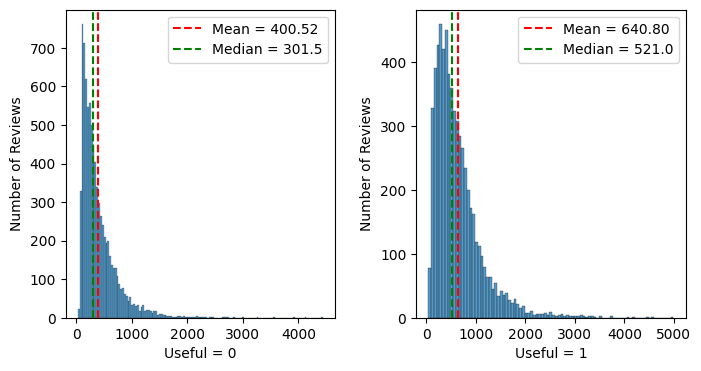

In [ ]:
reviews_0 = [len(i) for i in text_data[labels_classification == 0]]
reviews_1 = [len(i) for i in text_data[labels_classification == 1]]

fig, ax = plt.subplots(ncols=2, figsize=(8, 4) , gridspec_kw={'wspace': 0.3})

sns.histplot(reviews_0, ax=ax[0])
ax[0].set_xlabel('Useful = 0', fontsize=10)
ax[0].set_ylabel('Number of Reviews', fontsize=10)

mean_0 = np.mean(reviews_0)
median_0 = np.median(reviews_0)
ax[0].axvline(mean_0, color='r', linestyle='--',  label='Mean = {:.2f}'.format(mean_0))
ax[0].axvline(median_0, color='g', linestyle='--', label='Median = {}'.format(median_0))
ax[0].legend()

sns.histplot(reviews_1, ax=ax[1])
ax[1].set_xlabel('Useful = 1', fontsize=10)
ax[1].set_ylabel('Number of Reviews', fontsize=10)
mean_1 = np.mean(reviews_1)
median_1 = np.median(reviews_1)
ax[1].axvline(mean_1, color='r', linestyle='--', label= 'Mean = {:.2f}'.format(mean_1))
ax[1].axvline(median_1, color='g', linestyle='--', label='Median = {}'.format(median_1))
ax[1].legend()

plt.show()


We can see that on average, reviews with Useful votes are much longer: the average review has length of 640, compared to 400 in the "0" label reviews. It's possible that longer reviews tend to be more detailed and written with more thought - which would make them more useful. However, this is just a hypothesis and I did not directly attempt to test it in this project.

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import random
# # Load the pre-trained model
# word_model = tf.keras.models.load_model('pre_trained_glove_model.h5')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# set the maximum number of words to be used
max_words = 10000

# instantiate a tokenizer
tokenizer = Tokenizer(num_words=max_words)

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text_data)
random.seed(42)

indices = list(range(len(text_data))) # create a list of indices from 0 to 14499
sampled_indices = random.sample(indices, 5000) # get a random sample of 2000 indices

sample_data = text_data[sampled_indices]
labels_sample = labels_classification[sampled_indices]

sample_text_sequences = tokenizer.texts_to_sequences(sample_data)
maxlen = 2000
sample_text_sequences = pad_sequences(sample_text_sequences, maxlen=maxlen)

embedding_layer = Embedding(max_words, embedding_dim, input_length=maxlen,
                              weights=[embedding_matrix], mask_zero =True)

word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the text sequences for texts with label 0
text_sequences_0 = sample_text_sequences[labels_sample == 0]

# Get the embeddings for the text sequences
embedded_text_0 = embedding_layer(text_sequences_0)
embedded_text_0 = Flatten()(embedded_text_0)
embedded_text_0 = embedded_text_0.numpy()

# Get the text sequences for texts with label 1
text_sequences_1 = sample_text_sequences[labels_sample == 1]

# Get the embeddings for the text sequences
embedded_text_1 = embedding_layer(text_sequences_1)
embedded_text_1 = Flatten()(embedded_text_1)
embedded_text_1 = embedded_text_1.numpy()

# Calculate the cosine similarity between each text with label 0 and each text with label 1
similarity_matrix = cosine_similarity(embedded_text_0, embedded_text_1)

In [ ]:
# Get the indices of the 10 highest similarity scores
top_indices = np.argpartition(similarity_matrix, -10, axis=None)[-10:]
row_indices, col_indices = np.unravel_index(top_indices, similarity_matrix.shape)

idx_0 = [i for i,v in enumerate(labels_classification) if v==0]
idx_1 = [i for i,v in enumerate(labels_classification) if v==1]

# Sort the top indices based on similarity scores
sorted_indices = np.argsort(similarity_matrix[row_indices, col_indices])[::-1]
row_indices, col_indices = row_indices[sorted_indices], col_indices[sorted_indices]

# Print the top 10 similarity scores and corresponding texts.
# I am printing also the number of reviewers by reviewer (this is the normalized value, not the original), to identify cases of same reviewer
for row_idx, col_idx in zip(row_indices, col_indices):
    row_text = texts[idx_0[row_idx]]
    col_text = texts[idx_1[col_idx]]
    similarity_score = similarity_matrix[row_idx, col_idx]
    review_0_rating = df.iloc[idx_0[row_idx]]['review_rating']*5
    review_1_rating = df.iloc[idx_1[col_idx]]['review_rating']*5
    review_0_num_rev = df.iloc[idx_0[row_idx]]['review_reviewerReviewCount']
    review_1_num_rev = df.iloc[idx_1[col_idx]]['review_reviewerReviewCount']
    print(f"Text with label 0: {row_text}")
    print(f"Rating: {review_0_rating}")
    print(f"Number of reviews by the reviewer: {review_0_num_rev}")
    print(f"Text with label 1: {col_text}")
    print(f"Rating: {review_1_rating}")
    print(f"Number of reviews by the reviewer: {review_1_num_rev}")
    print(f"Similarity score: {similarity_score:.3f}\n")

Text with label 0: Delicious drinks and pastries, affordable prices, and everyone who works there is so sweet!
Rating: 5.0
Number of reviews by the reviewer: -0.2252510049662832
Text with label 1: This is right next Mike's pastries. The entrance is a bit hidden so just look closely. 
They could improve on their advertising by having their name in a big easel board in front of their store. Also, they need to showcase their pastries better.  These are homemade pastries! To see what they offer, i had to go near the bathroom and take a look. They are inside a fridge and it is not well lit...sigh!! Much can be improved. 
The coffee, hot chocolate and lobster tail was delicious! So yes, i do recommend this place.
Rating: 4.0
Number of reviews by the reviewer: -0.07660777963968075
Similarity score: 0.646

Text with label 0: Best brunch in Boston, Cambridge, greater Boston, possibly the planet. Lemon ricotta pancakes. The end.
Rating: 5.0
Number of reviews by the reviewer: -0.19948617924300543

#Conclusion

Overall, the different models that were explored preformed reasonably similar, and were able to learn and improve but didn't go over 70% accuracy in the main prediction task. The model that produced the highest accuracy was the CNN, and I followed through with its base structure for the other exploratory tasks.

To get better results, I would suggest the following:
1. Get more data! this turned to be very significant to the model performance.
2. Focus more on feature engineering. In this project, I focused mainly on the text data, but I feel there are important factors in the other data I haven't explored enough. Also, in terms of the text itself, I could have used its length as a predictor (as I have seen it is highly correlated with review usefulness label), and perhaps define key concepts for the model to detect in the text (such as numbers, sentiment words, tone, etc.).
3. Research into the original labels and try to see if they are reproducible by re-labeling using another source. This could help see if the original labels from the scraped data were somehow biased, and could improve prediction in case such bias was detected.
4. I would also like to explore more into the interpetation part of the results, as I briefly did in the last part; this means comparing different reviews, doing feature importance analysis, and so on. Eventually, the main use of this project is in **understanding** what makes a written text helpful to other people understanding/decision-making, etc. For that to happen, we must have an understanding of how the model works and a "black-box" model, even if highly accurate, would not be of much assistance.